# Single-cell triple omics sequencing reveals genetic, epigenetic, and transcriptomic heterogeneity in hepatocellular carcinomas

Dataset of simultaneous scRNAseq and single-cell reduced representation bisulfte sequencing (scRRBS).
The authors were able to infer CNV profiles using the scRRBS data which they confirm with bulk data and support with niave scRNA CNV profiles.

They note significant subpopulations of cells with private CNVs not detected in the bulk

GEO: GSE65364

SRA: SRP052901 

Healthy liver bulk RNASeq: ERR030887

In [1]:
import luigi
import rna2cn.luigi
from luigi import LocalTarget
from bioluigi.decorators import inherits, requires
from bioluigi.slurm import SlurmExecutableTask, SlurmTask
from bioluigi.utils import CheckTargetNonEmpty
import os,pyensembl
import logging
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.decomposition
import pickle

%matplotlib inline
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
cd /srv/shared/vanloo/rna2cn/SRP052901

/srv/shared/vanloo/rna2cn/SRP052901


In [3]:
sample_table = pd.read_csv("/srv/shared/vanloo/rna2cn/SRP052901/sample_table.csv")
run_table = pd.read_table("/srv/shared/vanloo/rna2cn/SRP052901/run_table.tsv")

sample_table['Name'] = sample_table['Experiment Title'].apply(lambda x : re.match('\S+: (\S+);.*', x).groups()[0])
sample_table['isBulk'] = sample_table['Experiment Title'].str.contains('bulk')
sample_table = sample_table.merge(run_table, left_on='Experiment Accession', right_on='Experiment_s')
sample_table.set_index('Run_s', inplace=True)

cols = sample_table.columns
cols = cols.map(lambda x: x.replace(' ', '_') if isinstance(x, str) else x)
sample_table.columns = cols

sample_table.drop(['ReleaseDate_s', 'Platform_s', 'LibraryLayout_s', 'Consent_s', 'MBytes_l', 
                   'Instrument', 'Submitter', 'Study_Accession', 'Study_Title', 'Total_Spots', 'Total_RUNs',
                   'Total_Spots','Total_Bases','BioSample_s','AvgSpotLen_l', 'BioProject_s', 'Center_Name_s',
                  'Sample_Title', 'Library_Name', 'Organism_s', 'InsertSize_l', 'passage_s','SRA_Study_s',
                  'MBases_l', 'SRA_Sample_s','Instrument_s', 'LoadDate_s'], axis=1, inplace=True)

sample_table = sample_table.append(pd.Series({ 'Name':'bulk_liver_RNA', 
                                              'Library_Source':"TRANSCRIPTOMIC", 
                                              'isBulk':True, 
                                              'Organism_Name':'Homo sapiens', 
                                              'tissue_s':'adult liver', 
                                              'source_name_s':"human adult liver tissue"}, name='ERR030887'))
sample_table.head()

,Experiment_Accession,Experiment_Title,Organism_Name,Sample_Accession,"Total_Size,_Mb",Library_Strategy,Library_Source,Library_Selection,Name,isBulk,Assay_Type_s,Experiment_s,LibrarySelection_s,LibrarySource_s,Sample_Name_s,source_name_s,tissue_s,gender_s
Run_s,,,,,,,,,,,,,,,,,,
SRR3102618,SRX1531594,GSM2039773: bulk_HepG2_gDNA; Homo sapiens; Bis...,Homo sapiens,SRS1248904,546.42,Bisulfite-Seq,GENOMIC,Reduced Representation,bulk_HepG2_gDNA,True,Bisulfite-Seq,SRX1531594,Reduced Representation,GENOMIC,GSM2039773,HepG2 cell line,hepatocellular carcinoma,male
SRR3102617,SRX1531593,GSM2039772: bulk_HepG2_RRBS; Homo sapiens; Bis...,Homo sapiens,SRS1248905,2706.11,Bisulfite-Seq,GENOMIC,Reduced Representation,bulk_HepG2_RRBS,True,Bisulfite-Seq,SRX1531593,Reduced Representation,GENOMIC,GSM2039772,HepG2 cell line,hepatocellular carcinoma,male
SRR3102616,SRX1531592,GSM2039771: bulk_HepG2_RNA; Homo sapiens; RNA-Seq,Homo sapiens,SRS1248906,1614.42,RNA-Seq,TRANSCRIPTOMIC,cDNA,bulk_HepG2_RNA,True,RNA-Seq,SRX1531592,cDNA,TRANSCRIPTOMIC,GSM2039771,HepG2 cell line,hepatocellular carcinoma,male
SRR3102615,SRX1531591,GSM2039770: scRNA-seq_HepG2_2; Homo sapiens; R...,Homo sapiens,SRS1248907,724.66,RNA-Seq,TRANSCRIPTOMIC,cDNA,scRNA-seq_HepG2_2,False,RNA-Seq,SRX1531591,cDNA,TRANSCRIPTOMIC,GSM2039770,HepG2 cell line,hepatocellular carcinoma,male
SRR3102614,SRX1531590,GSM2039769: scRNA-seq_HepG2_1; Homo sapiens; R...,Homo sapiens,SRS1248908,703.82,RNA-Seq,TRANSCRIPTOMIC,cDNA,scRNA-seq_HepG2_1,False,RNA-Seq,SRX1531590,cDNA,TRANSCRIPTOMIC,GSM2039769,HepG2 cell line,hepatocellular carcinoma,male


# RNA pipeline

In [4]:
rna_accesions = list(sample_table.query("Library_Source == 'TRANSCRIPTOMIC'").index) + ['ERR030887']

In [5]:
class FastqDump(SlurmExecutableTask):
    sample = luigi.Parameter()
    base_dir = luigi.Parameter("/srv/shared/vanloo/rna2cn/SRP052901/RNA")
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.partition = 'main'
        self.mem = 4000
        self.n_cpu = 1
    
    def output(self):
        return [LocalTarget(os.path.join(self.base_dir, self.sample, self.sample + "_1.fastq.gz")),
                LocalTarget(os.path.join(self.base_dir, self.sample, self.sample + "_2.fastq.gz"))]
    
    def work_script(self):
        return '''#!/bin/bash
                    fastq-dump --split-3 --gzip --outdir {outdir}_temp {sample}
                    mv {outdir}_temp/* {outdir}
                    '''.format(outdir=os.path.dirname(self.output()[0].path),
                               sample=self.sample)
    
@requires(FastqDump)
class Trimmomatic(rna2cn.luigi.Trimmomatic):
    pass

@requires(Trimmomatic)
class Kallisto(rna2cn.luigi.Kallisto):
    pass


@inherits(Kallisto)
class AggregateKallisto(rna2cn.luigi.AggregateKallisto):
    sample = None
    def requires(self):
        return {s: self.clone(Kallisto, sample=s) for s in rna_accesions} 
                        
                                                   
@inherits(Kallisto)    
class SampleWrapper(luigi.WrapperTask):
    sample = None
    def requires(self):
        return [self.clone(Kallisto, sample=s) for s in rna_accesions]

In [6]:
luigi.build([SampleWrapper(), AggregateKallisto()],local_scheduler=True, workers=2, log_level='INFO')

INFO: Informed scheduler that task   SampleWrapper__srv_shared_vanl_065e0448eb   has status   DONE
INFO: Informed scheduler that task   AggregateKallisto__srv_shared_vanl_065e0448eb   has status   DONE
INFO: Done scheduling tasks
INFO: Running Worker with 2 processes
INFO: Worker Worker(salt=444933559, workers=2, host=compute008, username=dbunting, pid=15600) was stopped. Shutting down Keep-Alive thread
INFO: 
===== Luigi Execution Summary =====

Scheduled 2 tasks of which:
* 2 present dependencies were encountered:
    - 1 AggregateKallisto(base_dir=/srv/shared/vanloo/rna2cn/SRP052901/RNA)
    - 1 SampleWrapper(base_dir=/srv/shared/vanloo/rna2cn/SRP052901/RNA)

Did not run any tasks
This progress looks :) because there were no failed tasks or missing external dependencies

===== Luigi Execution Summary =====



True

# Bisulfite Pipeline

In [7]:
rrbs_accesions = list(sample_table.query("Library_Strategy == 'Bisulfite-Seq'").index) 

In [9]:
class FastqDump(SlurmExecutableTask):
    sample = luigi.Parameter()
    base_dir = luigi.Parameter("/srv/shared/vanloo/rna2cn/SRP052901/RRBS")
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.partition = 'main'
        self.mem = 4000
        self.n_cpu = 1
    
    def output(self):
        return [LocalTarget(os.path.join(self.base_dir, self.sample, self.sample + "_1.fastq.gz")),
                LocalTarget(os.path.join(self.base_dir, self.sample, self.sample + "_2.fastq.gz"))]
    
    def work_script(self):
        return '''#!/bin/bash
                    fastq-dump --split-3 --gzip --outdir {outdir}_temp {sample}
                    mv {outdir}_temp/* {outdir}
                    '''.format(outdir=os.path.dirname(self.output()[0].path),
                               sample=self.sample)
    
@requires(FastqDump)
class Trimmomatic(rna2cn.luigi.Trimmomatic):
    pass

@requires(Trimmomatic)
class FastQC(rna2cn.luigi.FastQC):
    pass

@requires(Trimmomatic)
class Bismark(SlurmExecutableTask):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.partition = 'main'
        self.mem = 20000
        self.n_cpu = 5
    
    def output(self):
        return LocalTarget(os.path.join(self.base_dir, self.sample, 'bismark', self.sample + '_bismark.bam'))
    
    def work_script(self):
        return '''#!/bin/bash
                    module load SAMtools
                    mkdir {outdir}_temp
                    cd {outdir}_temp
                    
                    bismark --genome {genome} \
                            -1 {R1} -2 {R2} \
                            --multicore {n_cpu}\
                            --output_dir {outdir}_temp \
                            --non_directional 
                            
                    mv {outdir}_temp/trimmed_1_bismark_bt2_pe.bam {outdir}/{sample}_bismark.bam
                    mv {outdir}_temp/trimmed_1_bismark_bt2_PE_report.txt {outdir}/{sample}_bismark_bt2_PE_report.txt
                    '''.format(outdir=os.path.dirname(self.output().path),
                               R1=self.input()[0].path,
                               R2=self.input()[1].path,
                               n_cpu=self.n_cpu,
                               sample=self.sample,
                               genome='/srv/shared/vanloo/rna2cn/references/Homo_sapiens.GRCh38')
    
@requires(Bismark) 
class SamtoolsSort(rna2cn.luigi.SamtoolsSort):
    pass

@requires(SamtoolsSort) 
class SamtoolsDepth(rna2cn.luigi.SamtoolsDepth):
    pass

@requires(SamtoolsDepth, FastQC)
class PipelineWrapper(luigi.WrapperTask):
    pass

@inherits(PipelineWrapper)    
class SampleWrapper(luigi.WrapperTask):
    sample = None
    def requires(self):
        return [self.clone_parent(sample=s) for s in rrbs_accesions]

In [10]:
luigi.build([SampleWrapper()],local_scheduler=True, workers=60, log_level='INFO')

INFO: Informed scheduler that task   SampleWrapper__srv_shared_vanl_e53e2bc5c7   has status   DONE
INFO: Done scheduling tasks
INFO: Running Worker with 60 processes
INFO: Worker Worker(salt=525297781, workers=60, host=compute008, username=dbunting, pid=15600) was stopped. Shutting down Keep-Alive thread
INFO: 
===== Luigi Execution Summary =====

Scheduled 1 tasks of which:
* 1 present dependencies were encountered:
    - 1 SampleWrapper(base_dir=/srv/shared/vanloo/rna2cn/SRP052901/RRBS)

Did not run any tasks
This progress looks :) because there were no failed tasks or missing external dependencies

===== Luigi Execution Summary =====



True

# RNA single cell analysis

In [11]:
df = pd.read_table("/srv/shared/vanloo/rna2cn/SRP052901/RNA/kallisto_abundances.tsv", header=[0,1], index_col=0)
kallisto_tpm = df.xs('tpm', level=1, axis=1)
data = pyensembl.ensembl_grch38

# Match the column names
kallisto_tpm.columns = [sample_table['Name'][x] for x in kallisto_tpm.columns]
cols = list(kallisto_tpm.columns)
kallisto_tpm = kallisto_tpm.reset_index()
kallisto_tpm.columns = ['transcript_id'] + cols

# Drop transcripts with no expression
kallisto_tpm.drop( kallisto_tpm[ np.all(kallisto_tpm < 1e-3, axis = 1) ].index , axis=0, inplace=True)

# Query ensembl and get the gene_id for each transcript_id
gene_id = []
for i, x in enumerate(kallisto_tpm['transcript_id']):
    if i % 10000 == 0:
        print("Done {}".format(i))
    if 'ENST' in x: 
        try:
            gene_id.append(data.transcript_by_id(x.split('.')[0]).gene_id)
        except:
            gene_id.append('')
    else:
        gene_id.append(x)
        
kallisto_tpm['gene_id'] = gene_id
kallisto_tpm.drop('transcript_id', axis=1, inplace=True)
kallisto_tpm.drop(kallisto_tpm[kallisto_tpm['gene_id'] == ''].index, inplace=True)

# Sum over transcripts to get gene level TPM. 
kallisto_tpm = kallisto_tpm.groupby('gene_id').sum()

# Set genes with TPM < 1 to 0
kallisto_tpm = kallisto_tpm.where(kallisto_tpm > 1, other=0)
print(kallisto_tpm.shape)
# Drop genes expressed in < 10% of samples
kallisto_tpm.drop( kallisto_tpm[(kallisto_tpm > 0).mean(axis = 1) < 0.1].index , axis=0, inplace=True)
print(kallisto_tpm.shape)
# log transform
kallisto_tpm = np.log2(kallisto_tpm + 1)
# Drop the ERCC spike ins
kallisto_tpm.drop(kallisto_tpm[kallisto_tpm.index.str.contains('ERCC')].index, inplace=True, axis=0)

sc_cols = sample_table.query("Library_Source == 'TRANSCRIPTOMIC' and isBulk == False and Organism_Name == 'Homo sapiens'")
bulk_cols = sample_table.query("Library_Source == 'TRANSCRIPTOMIC' and isBulk == True and Organism_Name == 'Homo sapiens'")

kallisto_tpm.head()
kallisto_tpm.to_csv("./RNA/kallisto_gene_tpm.csv")

Done 0
Done 10000
Done 20000
Done 30000
Done 40000
Done 50000
Done 60000
Done 70000
Done 80000
Done 90000
Done 100000
Done 110000
Done 120000
Done 130000
(25025, 56)
(14354, 56)


In [12]:
pca = sklearn.decomposition.PCA(2)
sc_transformed = pca.fit_transform(kallisto_tpm[sc_cols['Name']].T)
bulk_transformed = pca.transform(kallisto_tpm[bulk_cols['Name']].T)

/home/dbunting/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


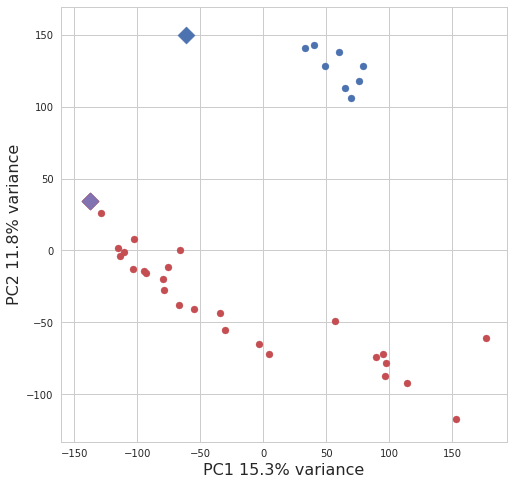

In [13]:
plt.figure(figsize=(8,8))

col_key = 'tissue_s'
sources = sample_table[col_key].unique() 
pal = {s: sns.color_palette(n_colors=len(sources))[i] for i,s in enumerate(sources)}

for i,(_,row) in enumerate(sc_cols.iterrows()):
    plt.scatter(sc_transformed[i,0], sc_transformed[i,1], 
                c=pal[row[col_key]], label=row[col_key])
    
for i,(_,row) in enumerate(bulk_cols.iterrows()):
    plt.scatter(bulk_transformed[i,0], bulk_transformed[i,1], 
                c=pal[row[col_key]], label=row[col_key], marker='D', s=150)


plt.xlabel("PC1 {0:.1f}% variance".format(pca.explained_variance_ratio_[0]*100), size=16)
plt.ylabel("PC2 {0:.1f}% variance".format(pca.explained_variance_ratio_[1]*100), size=16)


# RRBS CN Windowing

In [14]:
sample_depths = {s: SamtoolsDepth(sample=s).output().path for s in sample_table.query('Organism_Name == "Homo sapiens" and Library_Strategy == "Bisulfite-Seq"').drop('SRR3102618').index}

In [15]:
seq_dict = {}
with open('/srv/shared/vanloo/rna2cn/references/Homo_sapiens.GRCh38/Homo_sapiens.GRCh38.dna_sm.primary_assembly.dict', 'r') as f:
    for line in f:
        if line[:3] == '@HD':
            continue
        _,sn,ln,*_ = line.split("\t")
        seq_dict[sn[3:]] = int(ln[3:])

In [16]:
def window(depth_path, seq_dict, bin_size=1e7):
    depth_df = pd.read_table(depth_path, header=None, 
                             names=['chr', 'pos', 'depth'], 
                             dtype={'chr':np.str, 'pos':np.int, 'depth':np.int})

    # Drop the alternate/MT chromosomes
    depth_df.drop(depth_df[depth_df['chr'].str.startswith('G')].index, inplace=True)
    depth_df.drop(depth_df[depth_df['chr'].str.startswith('K')].index, inplace=True)
    depth_df.drop(depth_df[depth_df['chr'].str.startswith('M')].index, inplace=True)
    
    # Digitize into bins of size bin_size (except the final bin will be smaller)
    depth_df['bin'] = np.zeros(depth_df.shape[0], dtype=np.int)
    chromosomes = list(map(str, range(1,23))) + ['X']
    for chr in chromosomes:
        depth_df.loc[depth_df['chr'] == chr,'bin'] = np.digitize(depth_df[depth_df['chr'] == chr]['pos'], 
                                                                 bins=np.arange(0, seq_dict[chr], bin_size))
    binned_depth_df = depth_df.drop('pos', axis=1).groupby(['chr', 'bin']).sum()
    n_bins = binned_depth_df.index.levels[1].max()
    
    # Pad shorter chromosomes with Nan so all are the same size
    binned_depth = np.zeros((len(chromosomes), n_bins+1))/0
    for i, chr in enumerate(chromosomes):
        for j in range(max(binned_depth_df.loc[chr].index)):
            try:
                binned_depth[i,j] = int(binned_depth_df.loc[chr].loc[j+1])
            except KeyError:
                binned_depth[i,j] = 0
    
    # Normalise by number of reads in the samplw
    binned_depth = binned_depth / np.nansum(binned_depth, axis=1).reshape((-1,1))
    binned_depth = pd.DataFrame(binned_depth, index=chromosomes)
    return binned_depth

def window_pickle(sample_depths, ws,  path, seq_dict):
    # Be lazy and try and reload data
    if os.path.exists(path):
        with open(path, 'rb') as f:
            windowed = pickle.load(f)
    else:
        windowed = {}
        for k,v in sample_depths.items():
            print("Starting " + k)
            windowed[k] = window(v, seq_dict, ws)
            print("Done " + k)
        with open(path, 'wb') as f:
            pickle.dump(windowed, f)
            
   # Drop Y chromosome         
    for k in windowed.keys():
        try:
            windowed[k].drop('Y', inplace=True)
        except ValueError:
            pass
    return windowed
        
def normalise(data, controls):
    mean_ctrl = np.stack([np.array(v) for v in controls.values()]).mean(axis=0)
    return {k: np.where(mean_ctrl != 0, 2*v/mean_ctrl, 0) for k,v in data.items()}

def to_hmmlearn(normalised):
    collapsed, lengths, samples = [], [], []
    for k, sequence in normalised.items():
        data = np.ravel(sequence, order='C')   
        for i,d in enumerate(data):
            if np.isnan(d):
                if ~np.isnan(data[i-1]):
                    lengths.append(len(collapsed) - sum(lengths))
            else:
                collapsed.append(d)
        samples.append(k)
    return np.array(collapsed), lengths, samples

from hmmlearn.hmm import GaussianHMM
def hmm_fitdecode(normalised, diag_prior, **hmm_kwargs):
    comps=4
    hmm = GaussianHMM(n_components=comps,
                      means_prior=np.arange(1,5).reshape((-1,1)), 
                      means_weight=np.ones(comps).reshape((-1,1))*10000000, 
                      covariance_type = 'spherical',
                      transmat_prior=np.ones((comps,comps)) + np.eye(comps)*(diag_prior-1),
                      **hmm_kwargs)
    collapsed, lengths, samples = to_hmmlearn(normalised)
    hmm.fit(collapsed.reshape((-1, 1)), lengths)
    
    cumsum = [0] + list(np.cumsum(lengths))
    s, cn_state = hmm.decode(collapsed.reshape((-1, 1)), lengths)
    cn_states = [list(cn_state[cumsum[i]:cumsum[i+1]]) + [float('nan')] for i,_ in enumerate(lengths)]
    n_samples = int(len(cn_states)/23)
    cn_array = np.array([np.concatenate(cn_states[i*23:(i+1)*23]) for i in range(n_samples)])
    
    return cn_array, hmm, samples

def ravel_genome(data, chr_sep=None):
    '''Takes an array of nan padded chromosome sequences and unravels the
       into a single linear genome sequence optionally with a single value
       chr_sep separating chromosomes'''
    collapsed, lengths = [], []
    data = np.ravel(data, order='C')   
    for i,d in enumerate(data):
        if np.isnan(d):
            if ~np.isnan(data[i-1]):
                lengths.append(len(collapsed) - sum(lengths))
                if chr_sep is not None:
                    collapsed.append(chr_sep)
        else:
            collapsed.append(d)
    return collapsed, lengths

def plot_genome(data, ax=None):
    
    if ax is None:
        plt.figure(figsize=(24,2))
        ax = plt.gca()
        
    if data.shape[1] == 24 and data.shape[0] != 24:
        data = data.T
    data = np.ravel(data, order='C')
    collapsed, boundaries = [], []
    
    for i,d in enumerate(data):
        if np.isnan(d):
            if ~np.isnan(data[i-1]):
                boundaries.append(len(collapsed))
                collapsed.append(d)
        else:
            collapsed.append(d)
    ax.plot(range(len(collapsed)), collapsed, '.', color='black')
    ax.vlines(boundaries, 0,5)
    
def plothmm(cn_array, ax=None):
    ax = ax if ax else plt.gca()
    cnstate = np.arange(1,5)
    xticks = np.arange(len(cn_array))
    for c, cn in zip(sns.color_palette("Set2", 4), cnstate):
        ax.plot(xticks[cn_array == cn], cn_array[cn_array == cn], ".", color=c, label=str(cn),)

# 10Mb window size

In [17]:
windowed = window_pickle(sample_depths, 1e7,  "./windowed/windowed10.pickle", seq_dict)

## Primary hepatocellular carcinomas

In [21]:
liver_cancer = list(sample_table.query('tissue_s == "liver cancer" and Library_Strategy == "Bisulfite-Seq"').index)
healthy_liver = list(sample_table.query('tissue_s == "adult liver" and Library_Strategy == "Bisulfite-Seq"').index) 
liver_normalised = normalise({k:windowed[k] for k in liver_cancer+healthy_liver}, {k:windowed[k] for k in healthy_liver})
liver_cn, liver_hmm, liver_samples = hmm_fitdecode(liver_normalised, 5000, covars_prior=0.0001, covars_weight=1000, )#startprob_prior=np.array([0,1.0,0,0]))
print("HMM means: " + str(liver_hmm.means_.T))
print("HMM covars: " + str(liver_hmm.covars_.T))

HMM means: [[ 1.00002558  1.99999084  2.99999124  4.00000022]]
HMM covars: [[[ 0.22610768  0.0696721   0.08255197  0.00558453]]]


/home/dbunting/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


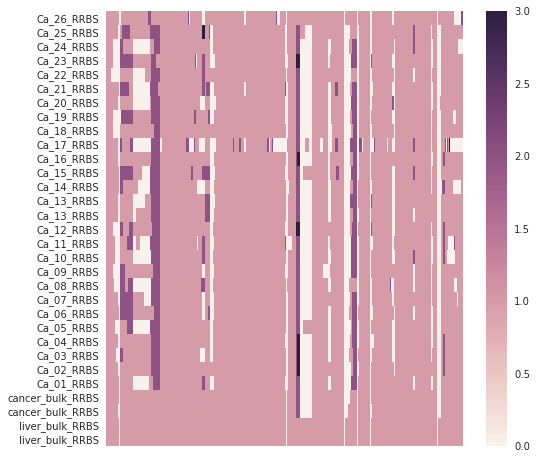

In [22]:
plt.figure(figsize=(8,8))
liver_df = pd.DataFrame(liver_cn, index=[sample_table.ix[x]['Name'] for x in liver_samples])
sns.heatmap(liver_df, xticklabels=False)

liver_df.to_csv("./windowed/windowed10_liver_cn.csv")

/home/dbunting/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


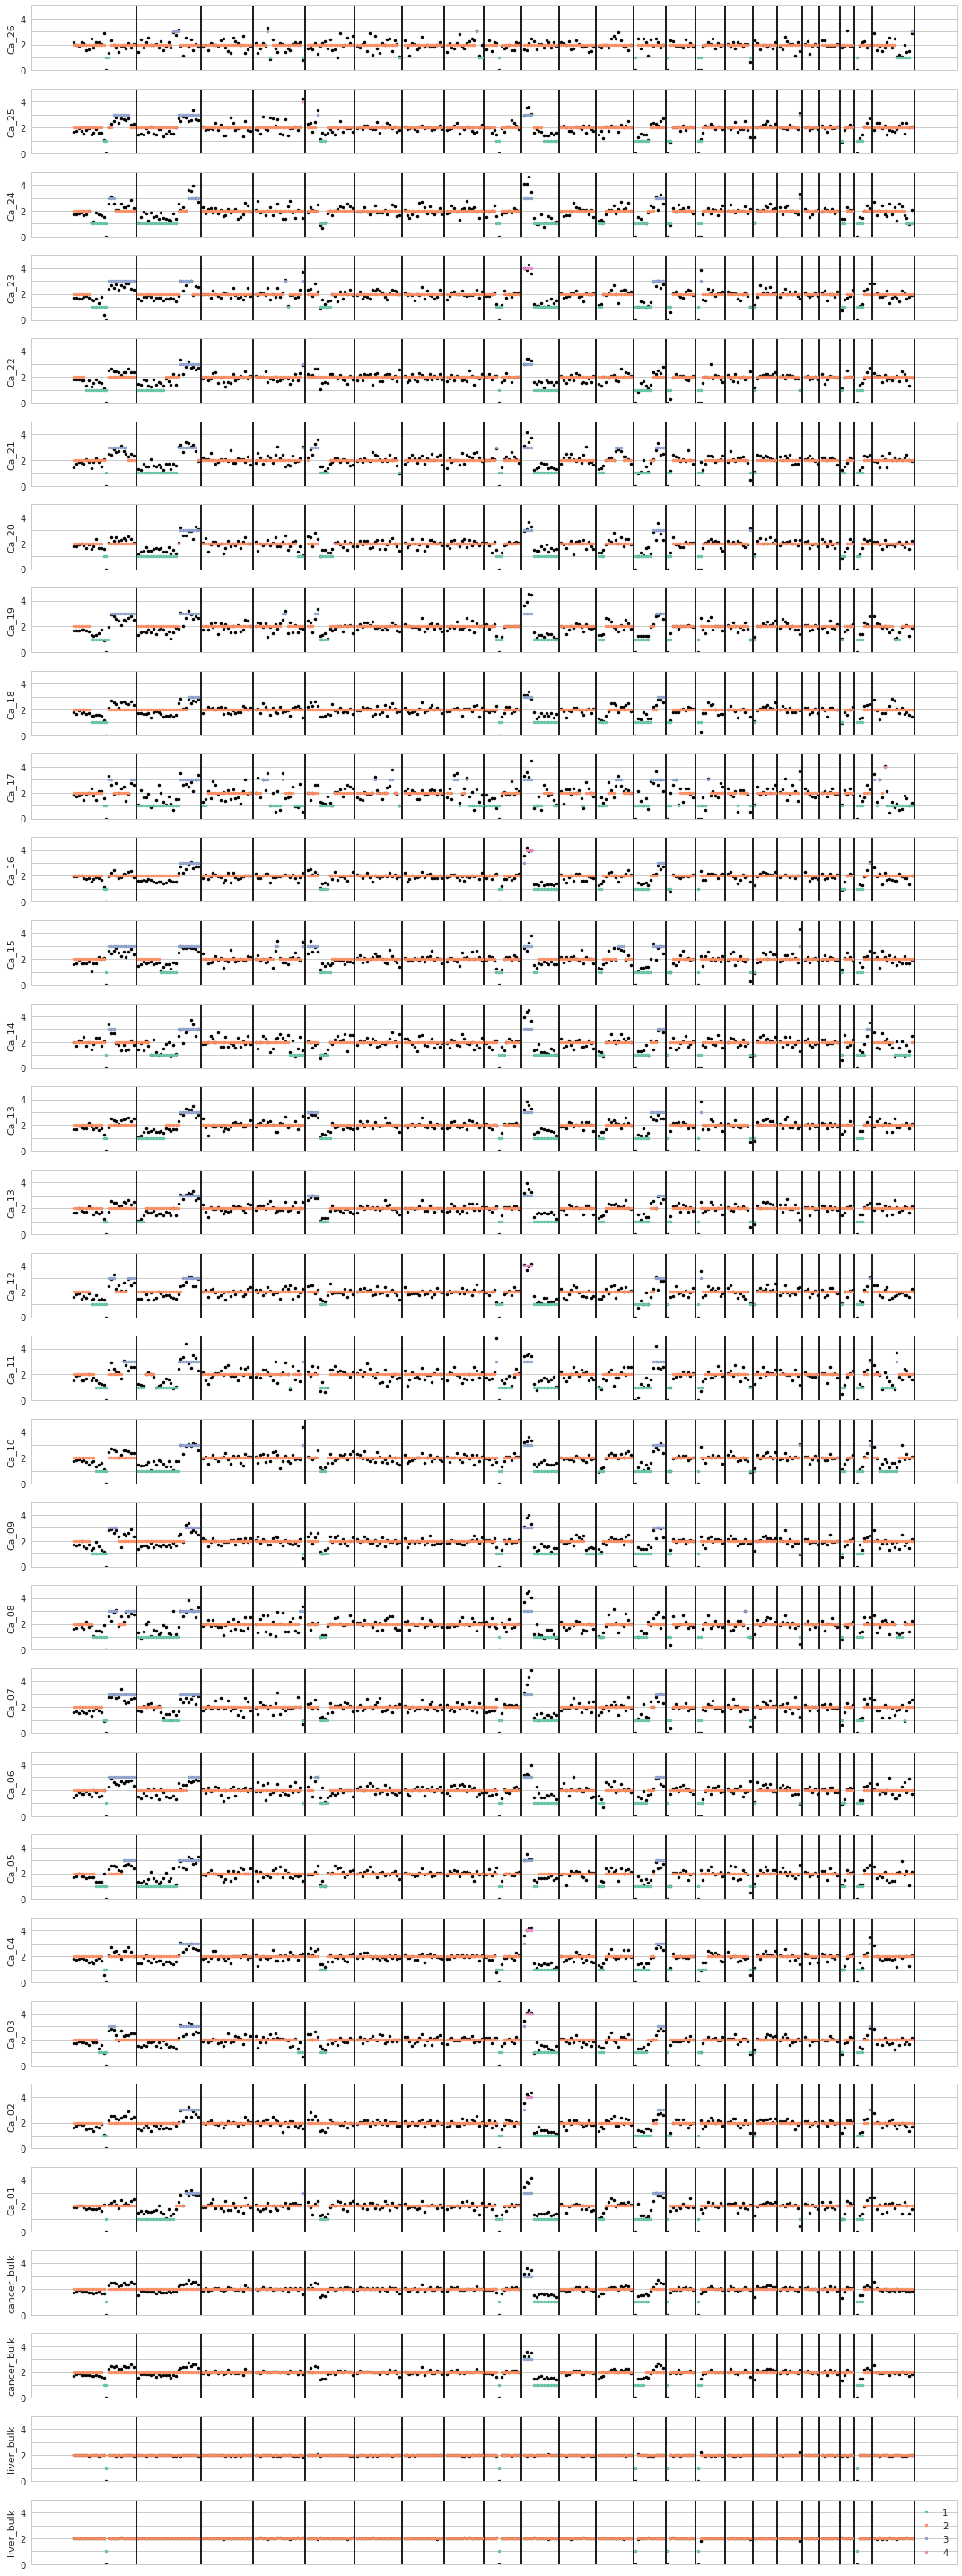

In [23]:
fig, ax = plt.subplots(len(liver_cancer+healthy_liver),1)
fig.set_size_inches((15, 40))
for i, k in enumerate(liver_cancer+healthy_liver):
    plot_genome(liver_normalised[k], ax=ax[i])
    ax[i].set_ylim((0,3))
    ax[i].set_yticks([0,1,2,3,4,5])
    ax[i].set_xticks([])
    ax[i].set_yticklabels(['0','','2','','4',''])
    ax[i].set_ylabel(sample_table.loc[k]['Name'].rsplit('_', 1)[0])
    plothmm(liver_cn[i]+1 , ax[i])
    
plt.tight_layout()
plt.legend()

## HepG2 Cell line

In [24]:
hepG2 = list(sample_table.query('source_name_s == "HepG2 cell line" and Library_Strategy == "Bisulfite-Seq"').drop('SRR3102618').index)
healthy_liver = list(sample_table.query('tissue_s == "adult liver" and Library_Strategy == "Bisulfite-Seq"').index)
hepG2_normalised = normalise({k:windowed[k] for k in hepG2+healthy_liver}, {k:windowed[k] for k in healthy_liver})
hepG2_cn, hepG2_hmm, hepG2_samples = hmm_fitdecode(hepG2_normalised, 50)
print("HMM means: " + str(liver_hmm.means_.T))
print("HMM covars: " + str(liver_hmm.covars_.T))

HMM means: [[ 1.00002558  1.99999084  2.99999124  4.00000022]]
HMM covars: [[[ 0.22610768  0.0696721   0.08255197  0.00558453]]]


/home/dbunting/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


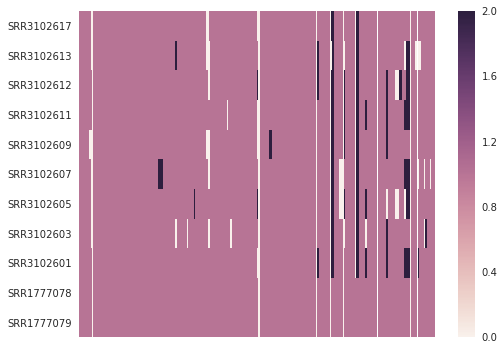

In [25]:
plt.figure(figsize=(8,6))
hepG2_df = pd.DataFrame(hepG2_cn, index=hepG2_samples)
sns.heatmap(hepG2_df, xticklabels=False)

hepG2_df.to_csv("./windowed/windowed10_hepG2_cn.csv")

/home/dbunting/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


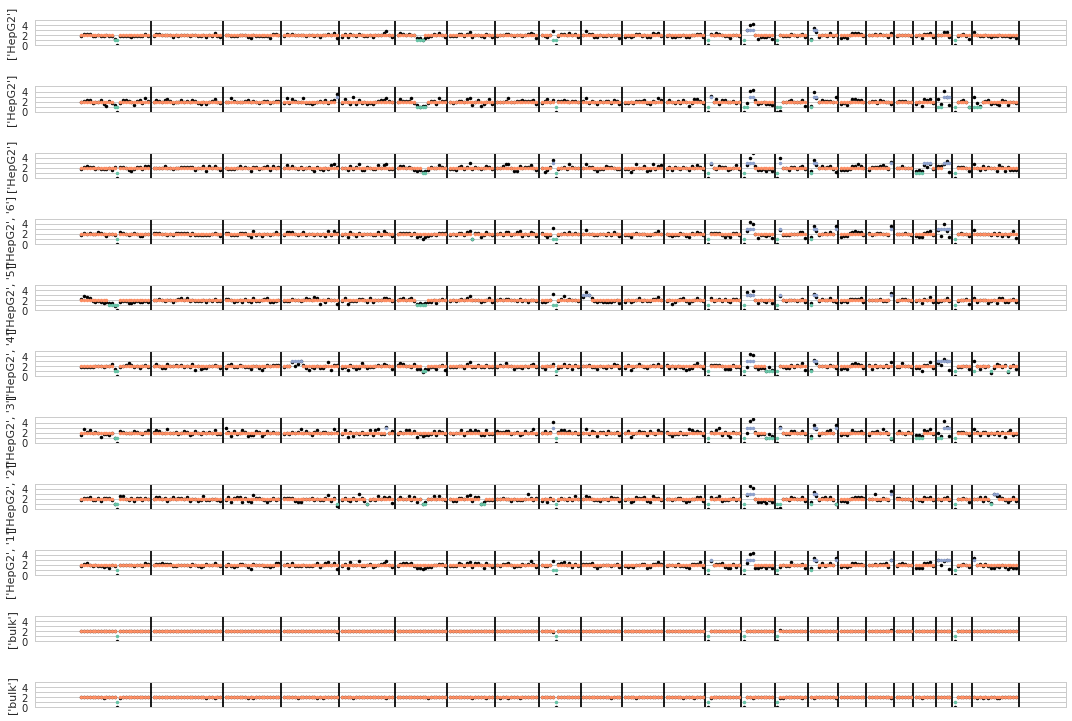

In [26]:
fig, ax = plt.subplots(len(hepG2+healthy_liver),1)
fig.set_size_inches((15, 10))
for i, k in enumerate(hepG2+healthy_liver):
    plot_genome(hepG2_normalised[k], ax=ax[i])
    ax[i].set_ylim((0,3))
    ax[i].set_yticks([0,1,2,3,4,5])
    ax[i].set_xticks([])
    ax[i].set_yticklabels(['0','','2','','4',''])
    ax[i].set_ylabel(sample_table.loc[k]['Name'].split('_')[1:-1])
    plothmm(hepG2_cn[i]+1, ax[i])
    
plt.tight_layout()

# 1Mb Window Size

In [27]:
windowed = window_pickle(sample_depths, 1e6,  "./windowed/windowed1.pickle", seq_dict)

## Primary hepatocellular carcinomas

In [28]:
liver_cancer = list(sample_table.query('tissue_s == "liver cancer" and Library_Strategy == "Bisulfite-Seq"').index)
healthy_liver = list(sample_table.query('tissue_s == "adult liver" and Library_Strategy == "Bisulfite-Seq"').index)
liver_normalised = normalise({k:windowed[k] for k in liver_cancer+healthy_liver}, {k:windowed[k] for k in healthy_liver})
liver_cn, liver_hmm, liver_samples = hmm_fitdecode({k: np.log1p(v) for k,v in liver_normalised.items()}, 50000, covars_prior=0.0001, covars_weight=100000, )#startprob_prior=np.array([1e-3,1.0,1e-3,1e-3]))
print("HMM means: " + str(liver_hmm.means_.T))
print("HMM covars: " + str(liver_hmm.covars_.T))

HMM means: [[ 1.00009242  1.99901724  2.9992524   3.99793156]]
HMM covars: [[[ 0.01996697  0.09242098  0.20457307  0.76203979]]]


In [ ]:
fig, ax = plt.subplots(len(liver_cancer+healthy_liver),1)
fig.set_size_inches((15, 40))
for i, k in enumerate(liver_cancer+healthy_liver):
    plot_genome({k: np.log1p(v) for k,v in liver_normalised.items()}[k], ax=ax[i])
    ax[i].set_ylim((0,3))
    ax[i].set_yticks([0,1,2,3,4,5])
    ax[i].set_xticks([])
    ax[i].set_yticklabels(['0','','2','','4',''])
    ax[i].set_ylabel(sample_table.loc[k]['Name'].rsplit('_', 1)[0])
    plothmm(liver_cn[i] +1 , ax[i])
    
plt.tight_layout()
plt.legend()

# Variable Bin Sizes

In [ ]:
healthy_liver = list(sample_table.query('tissue_s == "adult liver" and Library_Strategy == "Bisulfite-Seq"').index)
healthy_windows = {k: window(v , seq_dict, bin_size=1e5) for  k,v in sample_depths.items() if k in healthy_liver}

In [ ]:
plt.figure(figsize=(12,8))
for k,v in healthy_windows.items():
    plt.plot(np.cumsum(ravel_genome(v)[0]), label=k )
    plt.vlines(np.cumsum(ravel_genome(v)[1]), 0,25)
plt.legend()

In [ ]:
ravel_genome(healthy_windows['SRR1777078'].as_matrix())

In [ ]:
sample_table[['Ca_26' in x for x in sample_table['Name']]]